In [3]:
import pandas as pd
import numpy as np

# 1) Chargement
athletes = pd.read_csv('athlete_events.csv')
noc      = pd.read_csv('noc_regions.csv')

# 2) Médailles par pays/sport
data      = pd.merge(athletes, noc, on='NOC', how='left')
medals    = data.dropna(subset=['Medal'])
grouped   = (medals
             .groupby(['NOC','Sport'])
             .size()
             .reset_index(name='podium_count'))

# 3) max_podium & total_medals
max_pod   = grouped.groupby('NOC')['podium_count']\
                   .max()\
                   .rename('max_podium')
total_med = grouped.groupby('NOC')['podium_count']\
                   .sum()\
                   .rename('total_medals')

# 4) calcul de p_i et entropie Shannon
df = grouped.join(total_med, on='NOC')
df['p'] = df['podium_count'] / df['total_medals']

shannon = (df
           .assign(entropy=lambda d: -d['p'] * np.log(d['p']))
           .groupby('NOC')['entropy']
           .sum()
           .rename('H_shannon'))

# 5) nombre de sports S et normalisation
sports_count = grouped.groupby('NOC')['Sport']\
                      .nunique()\
                      .rename('S')

shannon_norm = (pd.concat([shannon, sports_count], axis=1)
                  .assign(H_norm=lambda d: d['H_shannon']/np.log(d['S']))
                  .reset_index())

# 6) corriger les NaN (pays avec S=1 → H_norm=0)
shannon_norm['H_norm'] = shannon_norm['H_norm'].fillna(0)

# 7) fusionner tout dans specialisation
specialisation = (
    max_pod.reset_index()
    .merge(total_med.reset_index(), on='NOC')
    .merge(shannon_norm[['NOC','H_norm']], on='NOC')
    .merge(noc[['NOC','region']], on='NOC', how='left')
)

# 8) calcul du ratio de spécialisation
specialisation['ratio_specialisation'] = (
    specialisation['max_podium']
    / specialisation['total_medals']
)

# 9) renommage et réorganisation
specialisation.rename(columns={'region':'Pays'}, inplace=True)
specialisation = specialisation[
    ['Pays','max_podium','total_medals','ratio_specialisation','H_norm']
]

print(specialisation.head())


          Pays  max_podium  total_medals  ratio_specialisation    H_norm
0  Afghanistan           2             2              1.000000  0.000000
1      Curacao           1             1              1.000000  0.000000
2      Algeria           9            17              0.529412  0.870229
3    Australia          15            29              0.517241  0.656772
4    Argentina          81           274              0.295620  0.733777


In [4]:
specialisation

,Pays,max_podium,total_medals,ratio_specialisation,H_norm
0,Afghanistan,2,2,1.000000,0.000000
1,Curacao,1,1,1.000000,0.000000
2,Algeria,9,17,0.529412,0.870229
3,Australia,15,29,0.517241,0.656772
4,Argentina,81,274,0.295620,0.733777
...,...,...,...,...,...
144,Vietnam,2,4,0.500000,0.946395
145,Trinidad,5,5,1.000000,0.000000
146,Serbia,84,390,0.215385,0.751113
147,Zambia,1,2,0.500000,1.000000


In [5]:
specialisation['Perf_H'] = (
    specialisation['total_medals']
    * specialisation['H_norm']
)


In [ ]:
pd.set_option("display.max_rows", None)

In [13]:
pd.reset_option("display.max_rows")

In [7]:
b = specialisation.sort_values(by=['ratio_specialisation'], ascending=False)

In [9]:
# dictionnaire de correspondances 'region' -> 'SOVEREIGNT'
overrides = {
    'USA': 'United States of America',
    'Trinidad': 'Trinidad and Tobago',
    'Serbia': 'Republic of Serbia',
    'Tanzania': 'United Republic of Tanzania',
    'UK': 'United Kingdom',
    'Bahamas': 'The Bahamas',
    'Macedonia': 'North Macedonia',
    'Czech Republic': 'Czechia'
    }

     
specialisation['SOVEREIGNT_corr'] = (
    specialisation['Pays']
    .replace(overrides)
    .astype(str)
)


In [14]:
specialisation

,Pays,max_podium,total_medals,ratio_specialisation,H_norm,Perf_H,SOVEREIGNT_corr
0,Afghanistan,2,2,1.000000,0.000000,0.000000,Afghanistan
1,Curacao,1,1,1.000000,0.000000,0.000000,Curacao
2,Algeria,9,17,0.529412,0.870229,14.793895,Algeria
3,Australia,15,29,0.517241,0.656772,19.046387,Australia
4,Argentina,81,274,0.295620,0.733777,201.055007,Argentina
...,...,...,...,...,...,...,...
144,Vietnam,2,4,0.500000,0.946395,3.785579,Vietnam
145,Trinidad,5,5,1.000000,0.000000,0.000000,Trinidad and Tobago
146,Serbia,84,390,0.215385,0.751113,292.933937,Republic of Serbia
147,Zambia,1,2,0.500000,1.000000,2.000000,Zambia


In [11]:
import geopandas as gpd 
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

In [22]:
# on va merge specialisation et world


merged = world.merge(specialisation, 
left_on = 'SOVEREIGNT',
right_on = 'SOVEREIGNT_corr',
how = 'left')

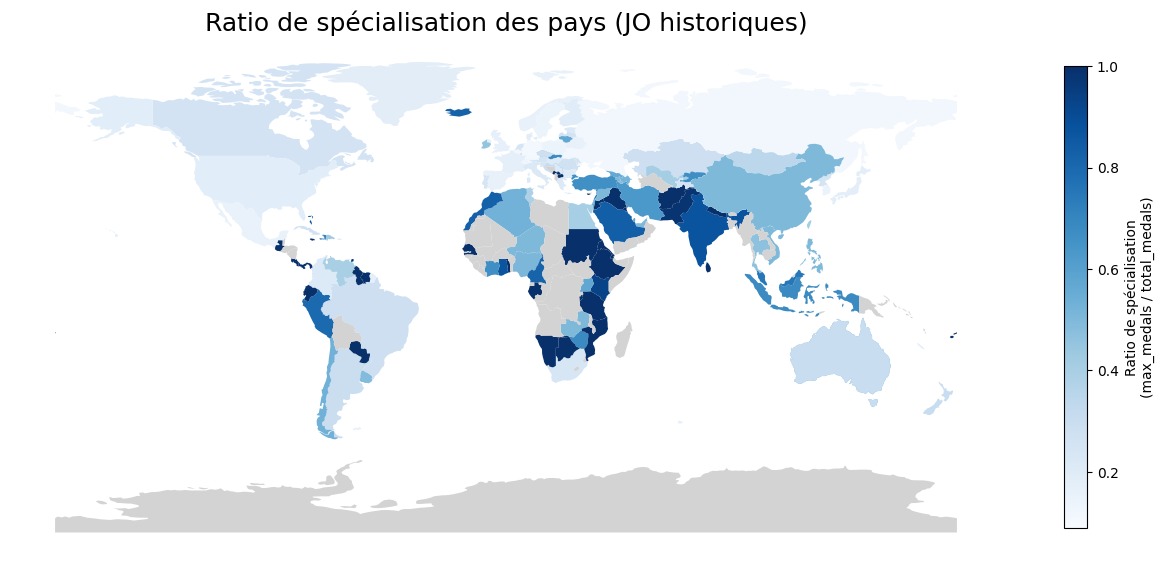

In [25]:
import matplotlib.pyplot as plt

# 5) Trace la choroplèthe
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
merged.plot(
    column='ratio_specialisation',
    ax=ax,
    legend=True,
    cmap = 'Blues',
    legend_kwds={
      'label': "Ratio de spécialisation\n(max_medals / total_medals)",
      'shrink': 0.6
    },
    missing_kwds={
      "color": "lightgrey",
      "label": "Pas de données"
    }
)

ax.set_title("Ratio de spécialisation des pays (JO historiques)", fontsize=18)
ax.set_axis_off()

plt.show()

juste pour voir, tester ce qui se passe si on fait merge = 'right'